<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/kang/rnnUnit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.optim
import numpy as np 
char_set = ['h', 'i', 'e', 'l','o']
x_data = [[0,1,0,2,3,3]]
x_one_hot = [[[1,0,0,0,0], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0],
             [0,0,0,1,0], [0,0,0,1,0]]]
y_data = [[1,0,2,3,3,4]]

input_size = len(char_set)
hidden_size = len(char_set)
learning_rate = 0.1


X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), learning_rate)

for i in range(100):
  optimizer.zero_grad()
  outputs, _status = rnn(X)
  loss = criterion(outputs.view(-1, input_size), Y.view(-1))
  loss.backward()
  optimizer.step()
  result = outputs.data.numpy().argmax(axis=2)
  result_str = ''.join([char_set[c] for c in np.squeeze(result)])
  print(i, "loss : ",loss.item(), " prediction : ", result, " true Y : ", y_data, " prediction str : ", result_str)


0 loss :  1.5023871660232544  prediction :  [[3 3 3 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  llllll
1 loss :  1.3443511724472046  prediction :  [[3 3 2 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  llelll
2 loss :  1.2347151041030884  prediction :  [[1 3 2 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  ilelll
3 loss :  1.1592987775802612  prediction :  [[1 3 2 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  ilelll
4 loss :  1.047301173210144  prediction :  [[1 3 2 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  ilelll
5 loss :  1.0057692527770996  prediction :  [[1 3 2 3 3 4]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  ilello
6 loss :  0.9408038258552551  prediction :  [[1 0 2 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  ihelll
7 loss :  0.8864296078681946  prediction :  [[1 0 2 3 3 3]]  true Y :  [[1, 0, 2, 3, 3, 4]]  prediction str :  ihelll
8 loss :  0.8458597660064697  prediction :  [[1 0 2 3 3 3

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [34]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
  )

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in findFiles('gdrive/My Drive/data/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines
  
n_categories = len(all_categories)

if n_categories == 0:
  raise RuntimeError('Data not found.')
  
print('# categories : ', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories :  18 ['Korean', 'Polish', 'Scottish', 'Vietnamese', 'Spanish', 'Portuguese', 'Russian', 'English', 'Chinese', 'Dutch', 'Czech', 'French', 'Irish', 'Greek', 'German', 'Italian', 'Japanese', 'Arabic']
O'Neal


In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    
    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [0]:
import random

#무작위 반환
def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

#임의의 category, 임의의 line
def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

In [0]:
#category one-hot vector
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

#처음부터 마지막(EOS빼고)까지의 one-hot 행렬
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

#두번째 문자부터 마지막(EOS)가지의 longTensor
def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters - 1)
  return torch.LongTensor(letter_indexes)

#임의의 category에서 category, input, target Tensor를 생성
def randomTrainingExample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return category_tensor, input_line_tensor, target_line_tensor

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

#모든 단계에서 예측을 수행 (모든 단계에서 손실 계산)
def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.initHidden()
  
  rnn.zero_grad()
  loss = 0
  
  #손실함수, loss
  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss += l
    
  loss.backward()
  
  for p in rnn.parameters():
    p.data.add_(-learning_rate, p.grad.data)
    
  return output, loss.item() / input_line_tensor.size(0)
    

In [0]:
import time
import math

#시간을 알기 위해 시간 문자열 반환
def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m * 60
  return '%dm %ds' % (m, s)

In [55]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

#train 호출, print_Every마다 시간과 손실 출력
for iter in range(1, n_iters + 1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss
  
  if iter % print_every == 0:
    print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
    
  #all_losses에 평균 손실 저장
  if iter % plot_every == 0:
    all_losses.append(total_loss / plot_every)
    total_loss = 0

0m 19s (5000 5%) 2.6444
0m 38s (10000 10%) 2.4867
0m 58s (15000 15%) 3.9912
1m 17s (20000 20%) 2.2756
1m 36s (25000 25%) 2.1359
1m 55s (30000 30%) 3.2848
2m 14s (35000 35%) 2.6175
2m 33s (40000 40%) 2.2653
2m 52s (45000 45%) 2.3834
3m 11s (50000 50%) 2.2265
3m 30s (55000 55%) 1.6757
3m 49s (60000 60%) 2.8886
4m 9s (65000 65%) 2.7583
4m 28s (70000 70%) 2.8790
4m 47s (75000 75%) 2.3494
5m 6s (80000 80%) 2.2666
5m 25s (85000 85%) 1.1808
5m 44s (90000 90%) 2.8207
6m 4s (95000 95%) 3.4138
6m 23s (100000 100%) 1.7016


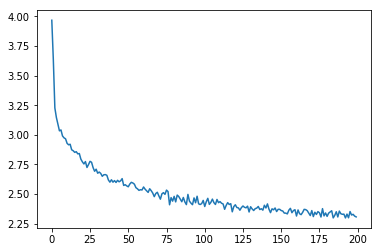

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [58]:
max_length = 20

def sample(category, start_letter='A'):
  with torch.no_grad(): #history 추적 안해도 됨
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.initHidden()
    output_name = start_letter
    
    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters-1:
        break;
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)
    return output_name
  
#한 카테고리와 여러 시작 문자들에서 샘플 얻기
def samples(category, start_letters='ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))
    
samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Roveri
Uarisher
Shavavav
Gerter
Eonter
Roste
Sara
Paner
Artaras
Cha
Han
Iu
